Does the residual still work if we use a buffered version?

Yes but it's a flattened version of the residual over the time.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
from src.sources.fft import FFTSource
from src.var_processor.sensor import Sensor

In [3]:
a = np.arange(0,5).reshape(-1, 1); print(a, a.ravel(), a.ravel().shape)

[[0]
 [1]
 [2]
 [3]
 [4]] [0 1 2 3 4] (5,)


In [4]:
class SensorVisualizer:
    """Object to visualise Sensor.
    
    We can likely make this simpler and more efficient once we
    get it working.
    
    """

    def __init__(self, sensor):
        """Initialise.

        Args:
            sensor - Sensor object.
        """
        self.sensor = sensor
        # Start sensor if not started
        if not self.sensor.source.started:
            self.sensor.start()
        # Get number of stages
        num_stages = self.sensor.num_stages
        # Initialise subplots for stages plus top level signal
        self.figure, self.axes = plt.subplots(num_stages+1, 2)
        # Initialising animation
        self.animation = FuncAnimation(
            self.figure, self.update, save_count=200)
        # Set up x ranges for each bar plot
        
        # First configure the raw data
        # self.d_length = self.sensor.get_data_length()
        # self.x_d_range = np.linspace(0, self.d_length-1, self.d_length)
        self.x_d_range = None
        # Then configure the causes and residuals lengths
        # This will just be a regular spaced set of ticks up to length
        # of each set of causes and each set of residuals
        #c_lengths, r_lengths = self.sensor.get_lengths() # Do I even need this - can I get in the update method?
        #self.x_c_ranges = [np.linspace(0, c_len-1, c_len) for c_len in c_lengths]
        #self.x_r_ranges = [np.linspace(0, r_len-1, r_len) for r_len in r_lengths]
        self.x_c_ranges = list()
        self.x_r_ranges = list()
        
        # Set up containers for bar plots
        self.data_bar = None
        self.cause_bars = list()
        self.residual_bars = list()
        
        # Set Titles
        self.axes[0][0].set_title("Signal & Causes")
        self.axes[0][1].set_title("Residuals")
        # Setup variable to store bar plots
        # Clear ticks
        for ax in self.axes.ravel():
            ax.xaxis.set_major_locator(plt.NullLocator())
            # ax.yaxis.set_major_locator(plt.NullLocator())
        plt.subplots_adjust(wspace=0.5)

    def update(self, frame):
        """Update the visualisations."""
        # Iterate sensor
        frame = self.sensor.iterate()
        causes = self.sensor.get_causes()
        residuals = self.sensor.get_residuals()
        
        # For bar plots we need to iterate through previous plots
        # and remove then replot
        
        # Redraw sensor data if exists - else set x range
        if self.data_bar:
            self.data_bar.remove()
        else:
            self.x_d_range = np.linspace(0, frame.shape[0]-1, frame.shape[0])
        self.data_bar = self.axes[0][0].bar(
            self.x_d_range,
            frame.ravel(),
            color='r'
        )    
        
        # Plot causes first  - iterate through axes[0, 1:]
        for i, cause in enumerate(causes):
            if i < len(self.cause_bars):
                self.cause_bars[i].remove()
            else:
                self.x_c_ranges.append(
                    np.linspace(0, cause.shape[0]-1, cause.shape[0])
                )
            bar = self.axes[i+1][0].bar(
                self.x_c_ranges[i],
                cause.ravel(),
                color='b'
            )
            if i < len(self.cause_bars):
                self.cause_bars[i] = bar
            else:
                self.cause_bars.append(bar)
        # Then plot residuals - iterate through axes[1, 1:]
        for i, residual in enumerate(residuals):
            if i < len(self.residual_bars):
                self.residual_bars[i].remove()
            else:
                self.x_r_ranges.append(
                    np.linspace(0, residual.shape[0]-1, residual.shape[0])
                )
            bar = self.axes[i][1].bar(
                self.x_r_ranges[i],
                residual.ravel(),
                color='g'
            )
            if i < len(self.residual_bars):
                self.residual_bars[i] = bar
            else:
                self.residual_bars.append(bar)
                
        # time.sleep(0.1)
        return self.figure

    def show(self):
        """Show the visualisations."""
        plt.show()

<IPython.core.display.Javascript object>


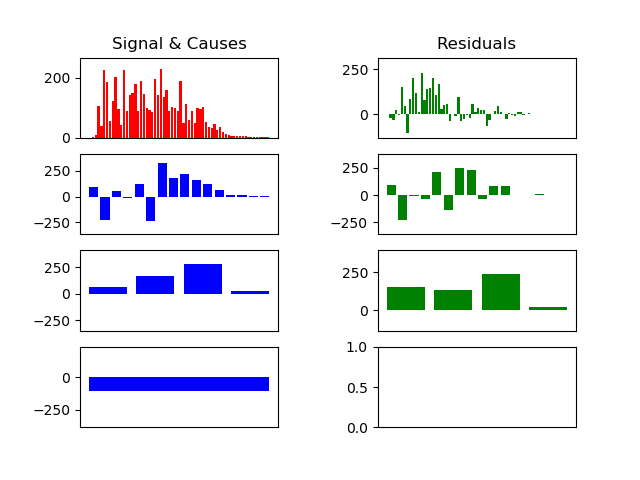

In [5]:
%matplotlib notebook
audio = FFTSource()
sensor = Sensor(audio, 4, 4)
sen_vis = SensorVisualizer(sensor)

In [6]:
sen_vis.cause_bars

[<BarContainer object of 16 artists>,
 <BarContainer object of 4 artists>,
 <BarContainer object of 1 artists>]

In [7]:
causes = sen_vis.sensor.get_causes()
print(causes[0].shape)

(16, 1)


In [8]:
for cause in causes:
    print(cause.ravel(), cause.shape)

[ 104.25710007 -223.49142457    7.52189813  -42.25556934  141.15595646
 -235.79352475  347.5696369   187.93752293  273.15581316  187.33829973
  147.27472311   80.22081422   21.06073027   11.06441299    8.43210616
    8.        ] (16, 1)
[  7.00736525 195.48443434 349.01776126  24.43889244] (4, 1)
[-190.53798928] (1, 1)


In [9]:
def test_sensor_visualiser():
    """Test the sensor visualiser."""
    # Test initialising
    audio = FFTSource()
    sensor = Sensor(audio, 4, 4)
    sen_vis = SensorVisualizer(sensor)
    assert self.axes.shape == (2, )
    

In [10]:
from src.var_processor.pb_threshold import pb_threshold

class PBTSensor(Sensor):
    """A sensor that implements probabilistic binary thresholding."""

    def get_frame(self):
        """Get a 1D frame of data from the sensor."""
        output = super(PBTSensor, self).get_frame()
        thresholded = pb_threshold(output.astype(np.uint8))
        return thresholded

<IPython.core.display.Javascript object>


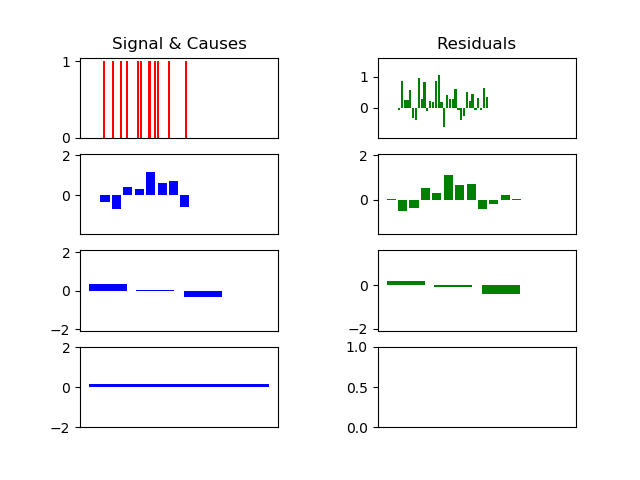

In [11]:
%matplotlib notebook
audio = FFTSource()
sensor = PBTSensor(audio, 4, 4)
sen_vis = SensorVisualizer(sensor)

It looks like we can also limit the causes to between 0 and 1. Running on live data the ranges mainly keep between 2 and -2. Interesting the last stage is mainly positive but the intermediate stages have negative values.

This suggests we need a bias to allow negative values.

<IPython.core.display.Javascript object>


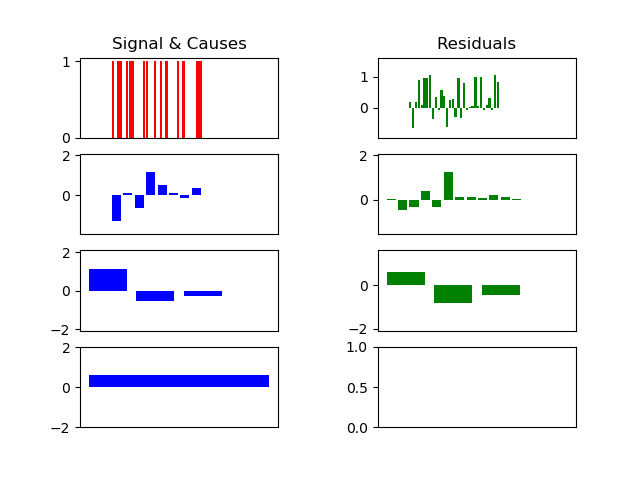

In [12]:
sen_vis.update(None)

# Making Binary

Add non_linearity() to outputs r and residual from the VPUs. This can consist of normalise() then PBTthreshold() on the existing output.

In [13]:
input_values = np.random.randint(255, size=200) / 128

In [14]:
%%timeit
non_lin_output = np.tanh(input_values)

5.64 µs ± 48.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [16]:
non_lin_output = np.tanh(input_values)
non_lin_output.dtype

dtype('float64')

<IPython.core.display.Javascript object>


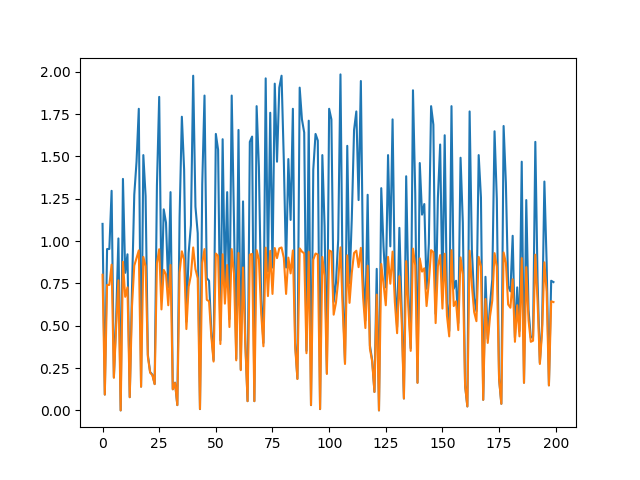

In [17]:
plt.plot(input_values)
plt.plot(non_lin_output)
plt.show()

In [18]:
%%timeit
non_lin_output = (input_values - input_values.min())/(input_values.max()-input_values.min())

ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})
ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})
ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})
ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})
ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})


26.5 µs ± 993 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})


<IPython.core.display.Javascript object>


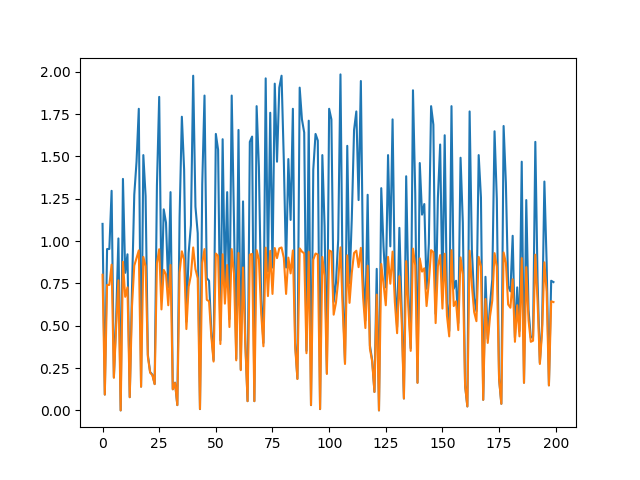

In [19]:
plt.plot(input_values)
plt.plot(non_lin_output)
plt.show()

But we'll need to convert to 8-bit following the tanh. Let's define a new float thresholder. We want to use the uniform distribution not the normal distribution.

In [20]:
def non_linearity(input_values):
    """Apply a non-linearity to the input."""
    # Initially use tanh as per Rao paper - it's also faster than max/min norm
    non_lin_output = np.tanh(input_values)
    # Add bias here - moves -ve values into +ve space
    biased = non_lin_output + 1
    # Now we need to convert to int to threshold? Why don't we define a float thresholder
    rand_ints = np.random.uniform(size=biased.shape)
    binary_values = np.where(input_values > rand_ints, 1, 0)
    return binary_values.astype(np.uint8)

In [21]:
%%timeit
output = non_linearity(input_values)

22.4 µs ± 1.28 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<IPython.core.display.Javascript object>


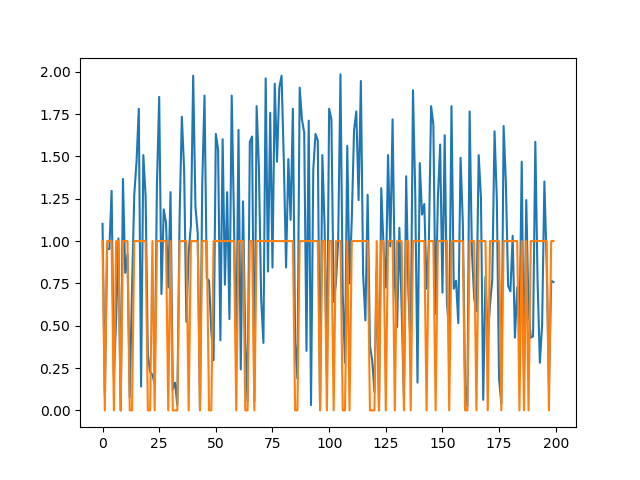

In [22]:
plt.plot(input_values)
plt.plot(non_linearity(input_values))
plt.show()

<IPython.core.display.Javascript object>


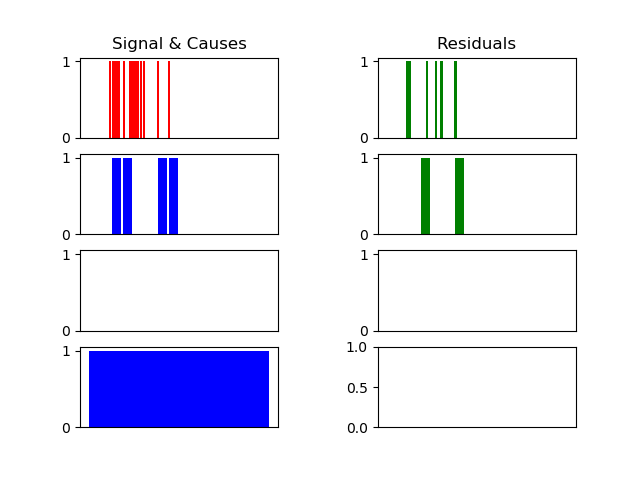

ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})
ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})
ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})


In [23]:
from src.var_processor.sensor import NonLinearSensor

%matplotlib notebook
audio = FFTSource()
sensor = NonLinearSensor(audio, 4, 4)
sen_vis = SensorVisualizer(sensor)